In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math

In [14]:
FILEPATH = r"C:\Users\iash.bashir\Downloads\Aerospace\project\data\Rocket Data.csv"
# Specify the path for the new text file

# Constants
MOTOR_NAME = "M2100F"
ROCKET_LENGTH = 2300
ALTITUDE_INCREMENTS = 1000
MAX_VERTICAL_MOTION = 400
MIN_VERTICAL_MOTION = -100
VERTICAL_MOTION_INCREMENTS = 50
THURST_CURVE_CSV = "project\data\AeroTech_M2100G.csv"
AVERAGE_THRUST = 2173.6

rename_dict = {"# Time (s)": "Time (s)"}

In [15]:
def read_csv_file(file_path):
    """
    Reads a CSV file and returns a DataFrame.
    """
    try:
        df = pd.read_csv(file_path, delimiter=",", skiprows=6)
        return df
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None


# Define a function to extract numerical time from the strings
def extract_time(text):
    match = re.search(r"t=([\d\.]+)", text)
    return float(match.group(1)) if match else None


def extract_comments(file_path):
    """
    Reads a CSV file and extracts rows that contain comments in the '# Time (s)' column.
    """
    df = read_csv_file(file_path)
    comments_df = df[df["# Time (s)"].astype(str).str.contains("#")].__deepcopy__()
    comments_df["Time (s)"] = comments_df["# Time (s)"].apply(
        lambda x: re.search(r"t=([\d\.]+)", x).group(1)
        if re.search(r"t=([\d\.]+)", x)
        else None
    )
    comments_df["Time (s)"] = pd.to_numeric(comments_df["Time (s)"], errors="coerce")
    comments_df["Event"] = (
        comments_df["# Time (s)"]
        .str.replace(r"occurred at t=[\d\.]+ seconds", "")
        .str.replace("#", "")
        .str.strip()
    )
    # Apply the function to the 'Event' column of your DataFrame
    comments_df["Event"] = comments_df["Event"].apply(remove_non_caps)

    # Rename 'LAUNCH' to 'LAUNCH/IGNITION'
    comments_df["Event"] = comments_df["Event"].replace({"LAUNCH": "LAUNCH/IGNITION"})
    # Rename 'BURNOUT' to 'BURNOUT/EJECTION_CHARGE'
    comments_df["Event"] = comments_df["Event"].replace(
        {"BURNOUT": "BURNOUT/EJECTION_CHARGE"}
    )
    # Rename 'GROUND_HIT' to 'GROUND_HIT/SIMULATION_END'
    comments_df["Event"] = comments_df["Event"].replace(
        {"GROUND_HIT": "GROUND_HIT/SIMULATION_END"}
    )

    # Remove the 'IGNITION' row
    comments_df = comments_df[comments_df["Event"] != "IGNITION"]
    # Remove the 'EJECTION_CHARGE' row
    comments_df = comments_df[comments_df["Event"] != "EJECTION_CHARGE"]
    # Remove the 'SIMULATION_END' row
    comments_df = comments_df[comments_df["Event"] != "SIMULATION_END"]

    return comments_df[["Time (s)", "Event"]]


def filter_comments_from_csv(file_path):
    """
    Reads a CSV file and filters out rows that contain comments.
    """
    df = read_csv_file(file_path)
    filtered_df = df[~df["# Time (s)"].astype(str).str.contains("#")].__deepcopy__()
    filtered_df["Time (s)"] = pd.to_numeric(filtered_df["# Time (s)"], errors="coerce")
    return filtered_df


def merge_dataframes(filtered_df, comments_df):
    """
    Merges the filtered DataFrame with the comments DataFrame.
    """
    merged_df = filtered_df.merge(comments_df, on="Time (s)", how="left")
    # Dropping the 'Time (s)' column from the merged DataFrame
    merged_df.drop(columns=["Time (s)"], inplace=True)

    # Ensure 'Time (s)' in filtered_df is float, if it's not already
    merged_df["# Time (s)"] = pd.to_numeric(merged_df["# Time (s)"], errors="coerce")
    return merged_df


def remove_non_caps(text):
    """
    Removes all words that are not in all caps from the given text.

    :param text: The string from which to remove non-uppercase words.
    :return: Modified string containing only uppercase words.
    """
    return " ".join(word for word in text.split() if word.isupper())


def remove_time_phrase(df):
    """
    Removes the 'occurred at t=number seconds' part from strings in the '# Time (s)' column.

    :param df: DataFrame containing the '# Time (s)' column with comment strings.
    :return: DataFrame with modified '# Time (s)' column.
    """

    # Define a function to remove the time phrase from the strings
    def remove_phrase(text):
        return re.sub(r"occurred at t=[\d\.]+ seconds", "", text).strip()

    # Apply the function to the '# Time (s)' column
    df["# Time (s)"] = df["# Time (s)"].apply(remove_phrase)
    return df

In [16]:
def plot_Flight_Profile(df):
    """Plot Flight Profile data."""
    # df = pd.read_csv(FLIGHT_PROFILE_CSV_FILE_PATH)
    df.rename(columns=rename_dict, inplace=True)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Altitude
    ax1.plot(df["Time (s)"], df["Altitude (ft)"], "k:", label="Altitude (ft)")
    ax1.set_xlabel("TIME (s)")
    ax1.set_ylabel("ALTITUDE (ft)")

    ax1.set_xlim(0, df["Time (s)"].max())

    MAX_ALTITUDE = math.ceil(int(df["Altitude (ft)"].max()) / 1000) * 1000
    ax1.set_ylim(0, MAX_ALTITUDE)

    ax1.set_yticks(range(0, MAX_ALTITUDE + 1, ALTITUDE_INCREMENTS))

    # Set the x-axis to have ticks at regular intervals
    x_ticks_interval = 10  # or any other interval suitable for your data
    ax1.set_xticks(
        np.arange(0, df["Time (s)"].max() + x_ticks_interval, x_ticks_interval)
    )
    
    ax1.grid(False)

    # Plot Vertical velocity and Vertical acceleration on the same axis, ax2
    ax2 = ax1.twinx()
    ax2.plot(
        df["Time (s)"],
        df["Vertical velocity (m/s)"],
        "k--",
        label="Vertical velocity (m/s)",
    )
    ax2.plot(
        df["Time (s)"],
        df["Vertical acceleration (m/s²)"],
        "k-",
        label="Vertical acceleration (m/s²)",
    )
    ax2.set_ylabel("VERTICAL VELOCITY (m/s); VERTICAL ACCELERATION (m/s²)", labelpad=15)
    ax2.set_ylim(MIN_VERTICAL_MOTION, MAX_VERTICAL_MOTION)
    ax2.set_yticks(
        np.arange(
            MIN_VERTICAL_MOTION,
            MAX_VERTICAL_MOTION + 1,
            VERTICAL_MOTION_INCREMENTS,
        )
    )

    # Combine legends from ax1 and ax2
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper right")

    plt.title(f"{MOTOR_NAME} Motor - Vertical Motion vs Time")
    fig.tight_layout()  # Adjust layout to fit labels
    plt.show()

In [17]:
df = pd.read_csv(FILEPATH, delimiter=',', skiprows=6)
display(df)

,# Time (s),Altitude (ft),Vertical velocity (m/s),Vertical acceleration (m/s²),Total velocity (m/s),Total acceleration (m/s²),Position East of launch (ft),Position North of launch (ft),Lateral distance (ft),Lateral direction (°),...,Reference length (mm),Reference area (cm²),Vertical orientation (zenith) (°),Lateral orientation (azimuth) (°),Wind velocity (m/s),Air temperature (°C),Air pressure (mbar),Speed of sound (m/s),Simulation time step (s),Computation time (s)
0,# Event LAUNCH occurred at t=0 seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,# Event IGNITION occurred at t=0 seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.01,-0.000769,-0.047,-4.685,0.047,4.685,0.000000,0.000000,0.000000,0.000000,...,153.0,180.0,90.011670,0.000000,2.220,15.000,1013.0,340.389,0.01,0.001
3,0.02,0.000907,0.055,5.533,0.055,5.533,0.000000,0.000000,0.000000,0.000000,...,153.0,180.0,90.011670,0.000000,2.232,15.000,1013.0,340.389,0.01,0.002
4,0.03,0.006562,0.213,15.756,0.213,15.756,0.000000,0.000000,0.000000,0.000000,...,153.0,180.0,90.011670,0.000000,2.244,15.000,1013.0,340.389,0.01,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3963,196.781,2.995407,-16.835,-0.415,27.265,0.429,-12330.843176,-70.200131,12331.043307,-179.679565,...,153.0,180.0,1.890761,0.916732,1.921,14.994,1013.0,340.385,0.05,1.236
3964,196.831,0.232940,-16.856,-0.416,27.282,0.434,-12334.360236,-70.252625,12334.560367,-179.679565,...,153.0,180.0,1.948057,0.916732,1.861,15.000,1013.0,340.389,0.05,1.236
3965,# Event GROUND_HIT occurred at t=196.881 seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3966,# Event SIMULATION_END occurred at t=196.881 s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
comments_df = extract_comments(FILEPATH)
display(comments_df)

,Time (s),Event
0,0.000,LAUNCH/IGNITION
7,0.060,LIFTOFF
25,0.227,LAUNCHROD
112,4.400,BURNOUT/EJECTION_CHARGE
504,23.881,APOGEE
3965,196.881,GROUND_HIT/SIMULATION_END


In [19]:
filtered_df = filter_comments_from_csv(FILEPATH)
display(filtered_df)

,# Time (s),Altitude (ft),Vertical velocity (m/s),Vertical acceleration (m/s²),Total velocity (m/s),Total acceleration (m/s²),Position East of launch (ft),Position North of launch (ft),Lateral distance (ft),Lateral direction (°),...,Reference area (cm²),Vertical orientation (zenith) (°),Lateral orientation (azimuth) (°),Wind velocity (m/s),Air temperature (°C),Air pressure (mbar),Speed of sound (m/s),Simulation time step (s),Computation time (s),Time (s)
2,0.01,-0.000769,-0.047,-4.685,0.047,4.685,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.220,15.000,1013.0,340.389,0.01,0.001,0.010
3,0.02,0.000907,0.055,5.533,0.055,5.533,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.232,15.000,1013.0,340.389,0.01,0.002,0.020
4,0.03,0.006562,0.213,15.756,0.213,15.756,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.244,15.000,1013.0,340.389,0.01,0.002,0.030
5,0.04,0.016404,0.473,25.984,0.473,25.984,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.256,15.000,1013.0,340.389,0.01,0.003,0.040
6,0.05,0.039370,0.835,36.218,0.835,36.218,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.268,15.000,1013.0,340.389,0.01,0.003,0.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,196.681,8.513780,-16.795,-0.389,27.233,0.397,-12323.809055,-70.098425,12324.009186,-179.679565,...,180.0,1.661578,0.916732,1.911,14.983,1013.0,340.379,0.05,1.235,196.681
3962,196.731,5.757874,-16.814,-0.399,27.248,0.410,-12327.326115,-70.150919,12327.526247,-179.679565,...,180.0,1.776169,0.916732,1.882,14.989,1013.0,340.382,0.05,1.236,196.731
3963,196.781,2.995407,-16.835,-0.415,27.265,0.429,-12330.843176,-70.200131,12331.043307,-179.679565,...,180.0,1.890761,0.916732,1.921,14.994,1013.0,340.385,0.05,1.236,196.781
3964,196.831,0.232940,-16.856,-0.416,27.282,0.434,-12334.360236,-70.252625,12334.560367,-179.679565,...,180.0,1.948057,0.916732,1.861,15.000,1013.0,340.389,0.05,1.236,196.831


In [20]:
merged_df = merge_dataframes(filtered_df, comments_df)
display(merged_df)

,# Time (s),Altitude (ft),Vertical velocity (m/s),Vertical acceleration (m/s²),Total velocity (m/s),Total acceleration (m/s²),Position East of launch (ft),Position North of launch (ft),Lateral distance (ft),Lateral direction (°),...,Reference area (cm²),Vertical orientation (zenith) (°),Lateral orientation (azimuth) (°),Wind velocity (m/s),Air temperature (°C),Air pressure (mbar),Speed of sound (m/s),Simulation time step (s),Computation time (s),Event
0,0.010,-0.000769,-0.047,-4.685,0.047,4.685,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.220,15.000,1013.0,340.389,0.01,0.001,NaN
1,0.020,0.000907,0.055,5.533,0.055,5.533,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.232,15.000,1013.0,340.389,0.01,0.002,NaN
2,0.030,0.006562,0.213,15.756,0.213,15.756,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.244,15.000,1013.0,340.389,0.01,0.002,NaN
3,0.040,0.016404,0.473,25.984,0.473,25.984,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.256,15.000,1013.0,340.389,0.01,0.003,NaN
4,0.050,0.039370,0.835,36.218,0.835,36.218,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.268,15.000,1013.0,340.389,0.01,0.003,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,196.681,8.513780,-16.795,-0.389,27.233,0.397,-12323.809055,-70.098425,12324.009186,-179.679565,...,180.0,1.661578,0.916732,1.911,14.983,1013.0,340.379,0.05,1.235,NaN
3955,196.731,5.757874,-16.814,-0.399,27.248,0.410,-12327.326115,-70.150919,12327.526247,-179.679565,...,180.0,1.776169,0.916732,1.882,14.989,1013.0,340.382,0.05,1.236,NaN
3956,196.781,2.995407,-16.835,-0.415,27.265,0.429,-12330.843176,-70.200131,12331.043307,-179.679565,...,180.0,1.890761,0.916732,1.921,14.994,1013.0,340.385,0.05,1.236,NaN
3957,196.831,0.232940,-16.856,-0.416,27.282,0.434,-12334.360236,-70.252625,12334.560367,-179.679565,...,180.0,1.948057,0.916732,1.861,15.000,1013.0,340.389,0.05,1.236,NaN


In [21]:
rows_with_events = merged_df[merged_df["Event"].notna()]
display(rows_with_events)

,# Time (s),Altitude (ft),Vertical velocity (m/s),Vertical acceleration (m/s²),Total velocity (m/s),Total acceleration (m/s²),Position East of launch (ft),Position North of launch (ft),Lateral distance (ft),Lateral direction (°),...,Reference area (cm²),Vertical orientation (zenith) (°),Lateral orientation (azimuth) (°),Wind velocity (m/s),Air temperature (°C),Air pressure (mbar),Speed of sound (m/s),Simulation time step (s),Computation time (s),Event
5,0.060,0.072178,1.299,46.457,1.299,46.457,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.278,15.000,1013.0,340.389,0.010,0.003,LIFTOFF
22,0.227,5.095144,19.040,126.791,19.040,126.791,0.000000,0.000000,0.000000,0.000000,...,180.0,90.011670,0.000000,2.219,14.990,1013.0,340.383,0.008,0.009,LAUNCHROD
108,4.400,3027.109580,302.640,-37.420,302.839,37.434,95.980971,0.016404,95.980971,0.009981,...,180.0,87.547951,0.002736,2.057,9.003,907.4,336.755,0.021,0.041,BURNOUT/EJECTION_CHARGE
498,23.881,10510.246063,-0.004,-9.688,4.138,9.690,491.387795,0.383858,491.387795,0.044937,...,180.0,56.207160,0.057296,1.807,-5.823,683.4,327.770,0.050,0.163,APOGEE
3958,196.881,-2.532808,-16.876,-0.422,27.300,0.444,-12337.880577,-70.305118,12338.080709,-179.679565,...,180.0,2.062648,0.916732,1.860,15.000,1013.0,340.389,0.050,1.236,GROUND_HIT/SIMULATION_END


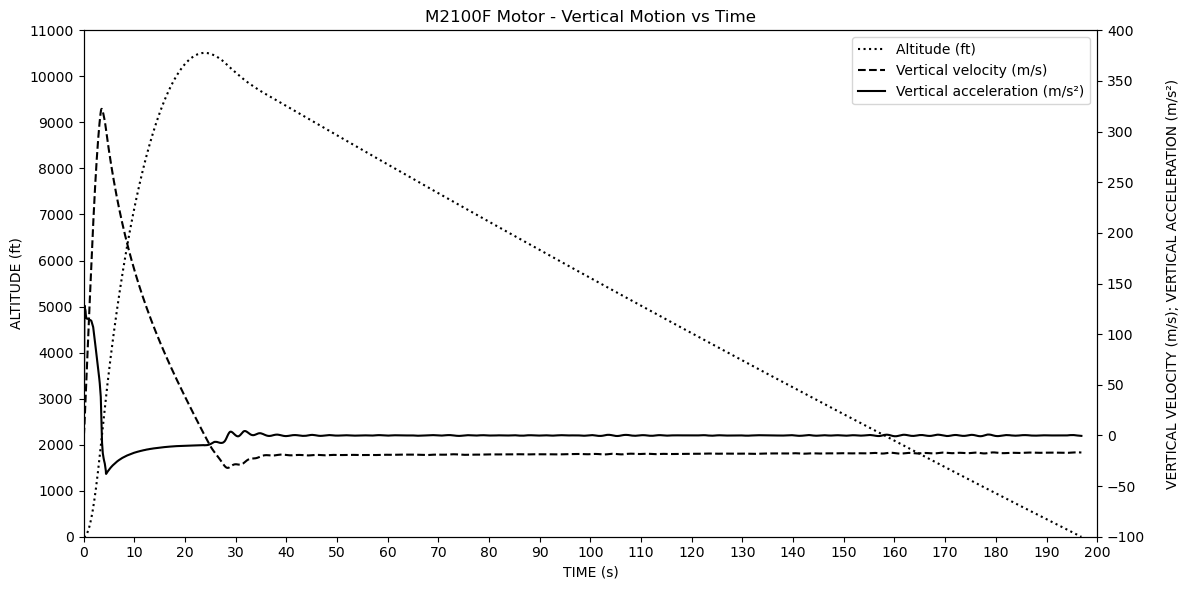

In [22]:
plot_Flight_Profile(merged_df)